# Discrétisation de l'équation de Poisson $ -\Delta u = f$ 

On s'intéresse à la discrétisation du problème suivant : 

$$\left\{
    \begin{array}{ll}
        -\Delta u = f & \mbox{sur } \Omega = [0,1]\times [0,1]\\
        u = 0 & \mbox{sur } \partial \Omega 
     \end{array}
 \right.
$$

On considère comme fonction $f$, la fonction suivante : 

$$ f(x_1,x_2) = 6(1-3x_1+2x_1^2)(x_2-1)^3x_2 + 6(1-3x_2+2x_2^2)(x_1-1)^3x_1$$. 

Dans le cadre de notre exercice, nous connaissons l'expression de $u$, solution exacte, qui est la suivante : 

$$u(x_1,x_2) = x_1x_2(x_1-1)^3(x_2-1)^3$$

Le but de cette première partie est de retrouver $u$ par différences finies. Pour cela nous écrirons une fonction qui retournera la matrice de discrétisation du Laplacien, nous résolverons ensuite le système et comparerons la solution approchée à celle connue. Nous utiliserons comme outil de programmation le langage python.

On commence par importer les packages dont nous avons besoin :

In [1]:
import numpy as np                        #Package pour calculs scientifiques
import scipy.sparse as sparse             #Algèbre linéaire creuse
import matplotlib.pyplot as plt           #Permet la création de graphique  
import scipy.sparse.linalg as sci         #Contient plusieurs packages pour le calcul scientifique
from mpl_toolkits.mplot3d import Axes3D   #Utile pou les graphiques 3D
import time                               #Affichage du temps de calcul

La fonction suivante permet d'écrire la matrice de la discrétisation du Laplacien. On découpe l'intervalle $[0,1]\times[0,1]$ en $N$ intervalles en $x$ et en $y$. Nous aurons donc $(N+1)\times(N+1)$ points. Cela implique que la matrice retournée est de taille $(N+1)\times(N+1)$.

In [3]:
def matrix_lap(N):
    """Retourne une matrice qui discrétise le laplacien de u dans le domaine Omega = [0,1]x[0,1], 
    découpé en N intervalles en x et y. La matrice finale est une matrice scipy.sparse CSR matrix. 
    Cette matrice est de taille (N+1)*(N+1)"""

    h = 1./N      #Longueur du pas d'espace
    h2 = h*h

    #On note les inconnues de 0 à Nx suivant x (axe des abscisses) 
    #et 0 à Ny suivant y (axe des ordonnées). 
    #La taille du problème est donc (Nx+1)*(Ny+1). 
    #Ici on prend le même pas d'espace en x et y
    #Cela correspond à x_i = i*h et y_j = j*h 
    #et la numérotation (i,j) --> k := (N+1)*j+i.

    taille = (1+N)*(1+N)
    
    #Rédaction de la matrice, on commence par effectuer 
    #le tableau des diagonales
    
    diags = np.zeros((5,taille))

    #Diagonale principale
    diags[2,:] = 1.
    diags[2, N+2:taille - (N+2)] = -4./h2
    diags[2, np.arange(2*N+1, taille, N+1)] = 1.
    diags[2, np.arange(2*N+2, taille, N+1)] = 1.
              
    #Diagonale "-1"
    diags[1,N+1:taille-(N+1)] = 1./h2
    diags[1, np.arange(2*N, taille, N+1)] = 0.
    diags[1, np.arange(2*N+1, taille, N+1)] = 0.
    
    #Diagonale "+1"
    diags[3, N+3:taille-(N+1)] = 1./h2
    diags[3, np.arange(2*N+2, taille, N+1)] = 0.
    diags[3, np.arange(2*N+3, taille, N+1)] = 0.

    #Diagonale "-(N+1)"
    diags[0, 1 : taille - (2*N+3)] = 1./h2
    diags[0, np.arange(N,taille,N+1)] = 0.
    diags[0, np.arange(N+1,taille,N+1)] = 0.

    #Diagonale "+(N+1)"
    diags[4, taille - N*N + 2 : taille - 1] = 1./h2
    diags[4, np.arange(taille - N*N + 1 + N ,taille,N+1)] = 0.
    diags[4, np.arange(taille - N*N + 2 + N ,taille,N+1)] = 0.

    #Construction de la matrice creuse
    A = sparse.spdiags(diags,[-(N+1),-1,0,1,(N+1)],taille,taille, format = "csr")

    return A

Munis de cette fonction, il ne nous reste plus qu'à résoudre le problème en suivant l'ordre de numérotation des sommets qui est le suivant : $$k = i + j\times(N+1) , \quad i = 0,\ldots,N, \quad j = 0,\ldots,N$$

Voyons ce que nous retourne la fonction matrix_lap pour N = 2 et N = 3 : 

In [4]:
print(matrix_lap(2).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.]
 [  0.   4.   0.   4. -16.   4.   0.   4.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   1.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.]]


In [5]:
print(matrix_lap(3).todense())

[[  1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.
    0.   0.]
 [  0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.   9.
    0.   0.]
 [  0.   0.   0.   0.   0.   0.   9.   0.   0.   9. -36.   9.   0.   0.
    9.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0

Nous pouvons également avoir un aperçu graphique de la matrice en utilisant la fonction "spy". Regardons pour $N = 5$ : 

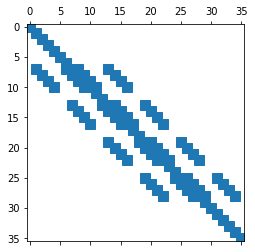

In [6]:
plt.spy(matrix_lap(5))
plt.show()

Par suite, nous écrivons le code pour définir la fonction $f$ et notre solution exacte $u$.

In [7]:
def f(x1,x2):
    return 6.*(1.-3.*x1+2.*x1**2)*((x2-1.)**3)*x2 + 6.*(1.-3.*x2+2.*x2**2)*((x1-1.)**3)*x1

def u(x1,x2):
    return x1*x2*((x1-1.)**3)*((x2-1))**3

On va résoudre le problème pour N = 100. Nous commençons par écrire notre maillage à l'aide de la fonction linspace qui permet un découpage homogène de l'intervalle $[0,1]$ en $N$ intervalles.

In [8]:
N = 100

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

On écrit la fonction qui retourne la solution approchée du problème. Pour résoudre le système linéaire, nous utiliserons dans un premier temps un solveur pour matrice sparse avec méthode directe. Nous verrons par la suite que pour un grand nombre d'intervalles il est préférable d'utiliser un solveur avec une méthode itérative.

In [9]:
def sol_disc(N):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    F = np.zeros((N+1)*(N+1))   #Allocation mémoire de f

    for i in np.arange(1,N):    #(1,N) car comme k = i + (N+1)*j 
                                #on s'assure que sur tous les bords f = 0.
        for j in np.arange(1,N):
            k = i + j*(N+1)
            F[k] = f(x[i],y[j])

    A = matrix_lap(N)           #Matrice de discrétisation du Laplacien
        
    U = sci.spsolve(A,F)        #Résolution du système linéaire AU = F 
                                #par solveur utilisant une méthode directe
    
    return U
    

Et nous affichons finalement la solution que nous allons directement comparer à la solution exacte.

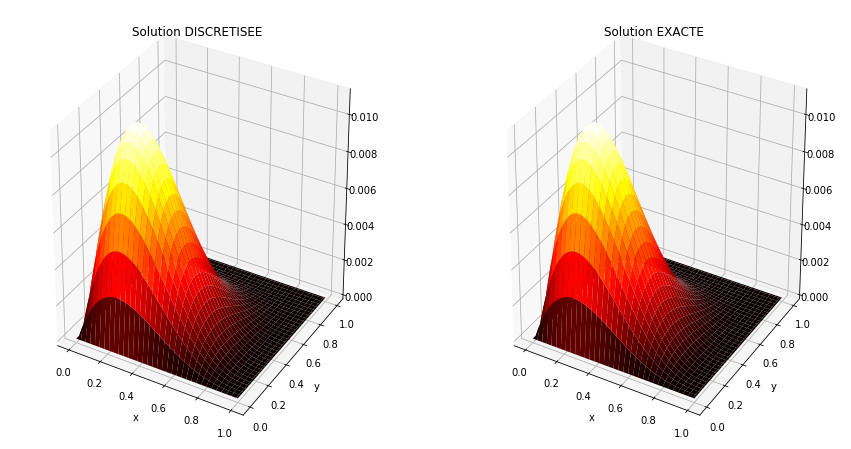

In [10]:
def sol_exacte(N):              #Fonction pour tracer la solution exacte
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    V = np.zeros((N+1)*(N+1))   #Allocation mémoire sol exacte
    
    for i in np.arange(N+1):
        for j in np.arange(N+1):
            k = i + j*(N+1)
            V[k] = u(x[i],y[j])

    return V


V = sol_exacte(N)         #On alloue à V la solution exacte
U = sol_disc(N)           #On alloue à U la solution approchée

fig = plt.figure(figsize = [15,8])                  #Création de l'environnement pour la figure

ax = fig.add_subplot(1,2,1, projection = '3d')      #Premier subplot pour la solution approchée
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y,U.reshape((N+1,N+1)),cmap = 'hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution DISCRETISEE")

ax = fig.add_subplot(1,2,2, projection = '3d')       #Second subplot pour la solution exacte
ax.plot_surface(X,Y, V.reshape((N+1,N+1)), cmap='hot')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Solution EXACTE")

plt.show()

On peut remarquer que les graphes sont très ressemblant, ce qui est une bonne nouvelle. Cependant, pour bien se rendre compte de la précision de notre schéma d'approximation, nous allons calculer l'erreur entre la solution approchée et celle exacte. Pour cela on définit deux fonctions d'erreur. La première est l'erreur dite euclidienne, définie par la formule : $$err_{eucl} = \sqrt{\dfrac {\sum_{i,j} (ex_{i,j} - app_{i,j})^2}{(N+1)^2}}$$
Puis nous calculerons l'erreur absolue définie par :$$ err_{abs} = \max_{i,j}{|ex_{i,j} - app_{i,j}|}$$

Nous calculons les erreurs précédentes toujours pour une valeur de $ N = 100$.

In [11]:
def erreur_eucl(A,E,N):
    return np.sqrt(np.sum((E-A)**2)/((N+1)**2))

err1 = erreur_eucl(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur demandée"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err1))

Taille   Erreur demandée
   10201  9.55422e-07


In [12]:
def erreur_abs(A,E,N):
    return np.max(np.abs(E - A))

err2 = erreur_abs(U,V,N)
print("{:8s} {:12s}".
    format("Taille", "Erreur absolue"))
print("{:8d} {:12.5e}".
    format((N+1)*(N+1), err2))

Taille   Erreur absolue
   10201  1.85769e-06


Finalement nous allons écrire le code pour afficher le graphique des 2 erreurs ci-dessus. Nous tracerons également la droite de régression linéaire afin de vérifier la justesse de nos résultats. Utilisant une méthode du second ordre, nous nous attendons à un coefficient directeur de -2. La fonction suivante affichera directement le graphique d'erreur, les 2 droites de régression et retournera les coefficients directeurs.

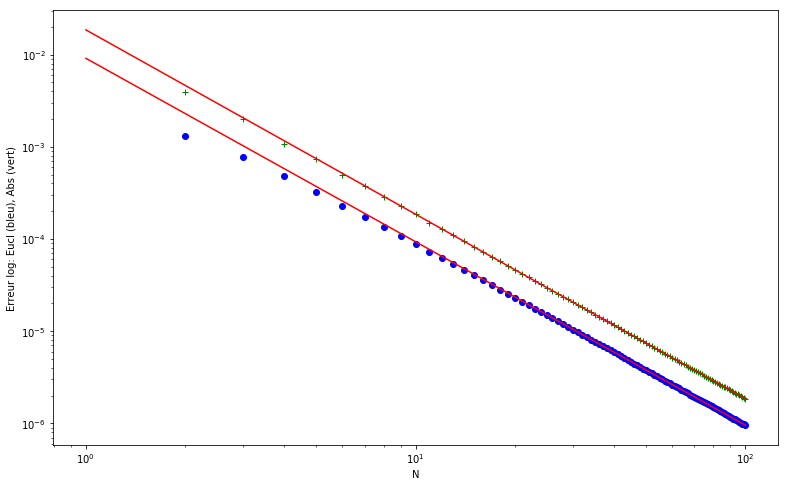

(-1.989640803920319, -1.9994143751986317)

In [13]:
def aff(x,b,a):                      #Création de la fonction pour régression linéaire
    return np.exp(b)*x**(a)

def graphe_erreur(N):                #Création de la fonction pour représenter les graphiques d'erreurs
    tab_err1 = np.zeros(N)
    tab_err2 = np.zeros(N)
    
    ERR1 = np.zeros(N)
    ERR2 = np.zeros(N)
    
    x = np.linspace(1,N,N)

    for i in range(1,N+1):        
        U = sol_disc(i)
        V = sol_exacte(i)

        tab_err1[i-1] = erreur_eucl(U,V,i)
        tab_err2[i-1] = erreur_abs(U,V,i)


    x1 = x[N-10:N]
    Err1 = tab_err1[N-10:N]
    Err2 = tab_err2[N-10:N]
    z1 = np.polyfit(np.log(x1),np.log(Err1),1)
    z2 = np.polyfit(np.log(x1),np.log(Err2),1)
        
    y1 = aff(x,z1[1],z1[0])  
    y2 = aff(x,z2[1],z2[0])

    plt.figure(figsize=[13,8])
    
    plt.plot(x,tab_err1,color='blue',marker='o', linestyle='none')
    plt.plot(x,tab_err2,color='green',marker='+', linestyle='none')
    plt.plot(x,y1,color='r', linestyle='-')
    plt.plot(x,y2,color='r', linestyle='-')
    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel('N')
    plt.ylabel('Erreur log: Eucl (bleu), Abs (vert)')

    plt.show()

    return z1[0],z2[0]

graphe_erreur(100)

Les coefficients directeurs obtenus justifient donc parfaitement la justesse de notre schéma. 

Pour conclure, nous allons observer l'intérêt d'utiliser des solveurs avec méthodes itératives pour résoudre nos systèmes linéaires. Pour cela, nous allons utiliser le package time qui renvoie le temps de calcul d'un programme. Nous allons écrire la même approximation mais nous utiliserons la méthode du gradient conjugué (utilisé ici car notre matrice sparse est bien définie positive). Nous allons alors procéder à l'affichage du temps pour $N = 100$ et $N=1000$.

In [14]:
def sol_disc_conjgrad(N):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)
    
    F = np.zeros((N+1)*(N+1))   #Allocation mémoire de f

    for i in np.arange(1,N):    #(1,N) car comme k = i + (N+1)*j on s'assure que 
                                #sur tous les bords f = 0.
        for j in np.arange(1,N):
            k = i + j*(N+1)
            F[k] = f(x[i],y[j])

    A = matrix_lap(N)           #Matrice de discrétisation du Laplacien
        
    U = sci.cg(A,F)             #Résolution du système linéaire AU = F par solveur 
                                #utilisant une méthode de gradient conjugué
    
    return U[0]

In [15]:
def temps_direct(N):
    start_time = time.time()
    U = sol_disc(N)
    print("Temps d execution directe: %s secondes " %(time.time() - start_time))
    
def temps_iterativ(N):
    start_time = time.time()
    U = sol_disc_conjgrad(N)
    print("Temps d execution itérative : %s secondes " %(time.time() - start_time))

In [20]:
temps_direct(100)
temps_iterativ(100)

Temps d execution directe: 0.1265411376953125 secondes 
Temps d execution itérative : 0.11231422424316406 secondes 


In [17]:
temps_iterativ(1000)

Temps d execution itérative : 83.88120746612549 secondes 


In [18]:
temps_direct(1000)

Temps d execution directe: 85.36850833892822 secondes 


On se rend compte que la méthode de résolution itérative, ici par méthode du gradient conjugué est plus rapide que son homologue directe. Comme nous n'utiliserons jamais un grand nombre d'intervalle dans la suite du rapport nous privilégierons l'utilisation de la méthode directe. 

# Interpolation du problème par des fonctions polynômiales

Dans cette seconde partie, nous cherchons à changer la valeur de la solution sur les bords. On s'intéresse à la discrétisation du problème suivante sur un domaine $\Omega = [0,1] \times [0,1]$ : $$ -\Delta u = 0 $$

Nous allons rajouter les conditions suivantes sur les bords : 

$$
u(x,\alpha,\beta) = \left\{
    \begin{array}{lll}
        u(x,\alpha) = x(x-\frac{1}{2})\alpha & \text{si } x \leq 0 & \text{sur le bord bas}\\
        0 & \text{sinon} & \text{sur le bord bas}\\
        u(x,\beta) = (x-1)(x-\frac{1}{2})\beta & \text{si  } x\geq 0 & \text{sur le bord haut}\\
        0 & \text{sinon} & \text{sur le bord haut}
     \end{array}
 \right.        
$$

L'interpolation dépend donc de deux paramètres réels $\alpha$ et $\beta$. On commence par définir les fonctions nécessaires.

In [16]:
def fb(x,y,alpha):                     #Fonction pour le bord haut dépendant de alpha
    return x*(x-(1./2.))*alpha

def fh(x,y,beta):                      #Fonction pour le bord bas dépendant de beta
    return (x-1.)*(x-(1./2.))*beta

Et on discrétise le problème de la façon suivante : 

In [17]:
def sol_disc_inter(N, alpha, beta):
    
    x = np.linspace(0,1,N+1)
    y = np.linspace(0,1,N+1)

    F = np.zeros((N+1)*(N+1))      #Matrice pour stocker les valeurs de f
                                   #avec les fonctions interpolées

    for i in np.arange(0,N+1):   
        for j in np.arange(0,N+1):
            k = i + j*(N+1)        
            if (i <= (N/2.) and j == 0):
                F[k] = fb(x[i],y[j],alpha)
            elif (i >= (N/2.) and j == N):
                F[k] = fh(x[i],y[j],beta)

    A = matrix_lap(N)              #Matrice de discrétisation du Laplacien
        
    U = sci.spsolve(A,F)            #On résoud le système linéaire AU = F 
                                    #par le solveur avec méthode directe    
    
    return U


Finalement, on procède à l'affichage pour une valeur de $N = 200$, $\alpha = -1$, $\beta = -1$

Text(0.5, 0, 'y')

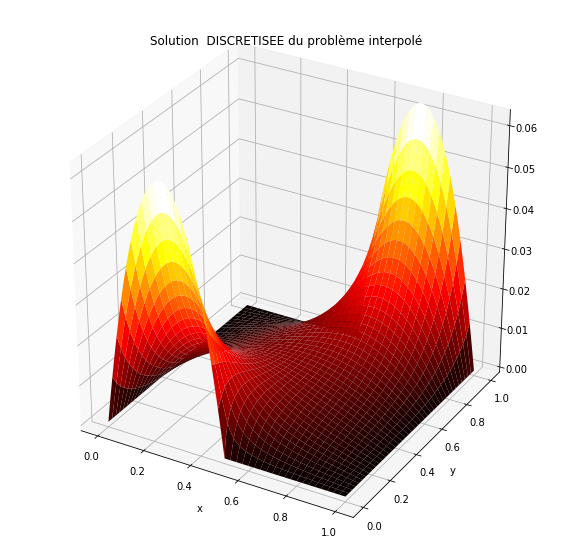

In [18]:
N = 200

x = np.linspace(0,1,N+1)
y = np.linspace(0,1,N+1)

U = sol_disc_inter(N,-1,-1)

fig = plt.figure(figsize = [10,10])

ax = fig.add_subplot(111 ,projection='3d')
X,Y = np.meshgrid(x,y)
ax.plot_surface(X,Y, U.reshape((N+1,N+1)), cmap='hot')

plt.title("Solution  DISCRETISEE du problème interpolé")
plt.xlabel("x")
plt.ylabel("y")